In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [3]:
!pip install segment_anything

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import glob
import os
import sys
sys.path.append('../src')
from model_UNet import UNet3D
from metrics import bce_dice_loss, dice_coefficient, batch_dice_coeff
from datasets import KneeSegDataset3D

In [5]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
# Define data path
DATA_DIR = '../data'

# Get the paths
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [7]:
test_paths

array(['test_001_V00', 'test_001_V01', 'test_002_V00', 'test_002_V01',
       'test_003_V00', 'test_003_V01', 'test_004_V00', 'test_004_V01',
       'test_005_V00', 'test_005_V01', 'test_006_V00', 'test_006_V01',
       'test_007_V00', 'test_007_V01', 'test_008_V00', 'test_008_V01',
       'test_009_V00', 'test_009_V01', 'test_010_V00', 'test_010_V01',
       'test_011_V00', 'test_011_V01', 'test_012_V00', 'test_012_V01',
       'test_013_V00', 'test_013_V01', 'test_014_V00', 'test_014_V01'],
      dtype='<U12')

In [8]:
# Define the dataset and dataloaders
test_dataset = KneeSegDataset3D(test_paths, DATA_DIR, split='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
im, seg = next(iter(test_loader))

In [10]:
seg.shape

torch.Size([1, 1, 200, 256, 160])

In [11]:
model = UNet3D(1,1,16)
#load trained model
PATH = '../models/high_lr_40_epoch_1_gpu.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval();

In [12]:
# Put in image and show out/mask comparison

im, seg = next(iter(test_loader))

In [13]:
im = im.to(device)
model.to(device)
out = model(im)

In [14]:
out = out.detach().cpu()

In [15]:
batch_dice_coeff(seg,out).item()

0.9137928485870361

(200, 256)


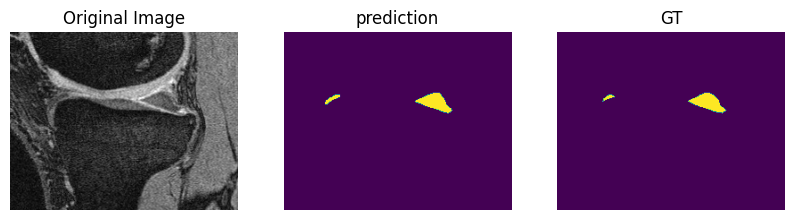

In [16]:
import matplotlib.pyplot as plt

slice_num = 100

out = out[0][0].detach().cpu().numpy()
binary_mask = (out>0.5).astype(int)
image = im[0][0].detach().cpu().numpy()
gt = seg[0][0]

binary_slice = binary_mask[...,slice_num]
image = image[...,slice_num]
gt = gt[...,slice_num]

print(binary_slice.shape)

# Display the original image and the overlayed image using plt.imshow
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_slice)
ax[1].set_title('prediction')
ax[1].axis('off')

ax[2].imshow(gt)
ax[2].set_title('GT')
ax[2].axis('off')

plt.show()

In [17]:
def show_mask_slices(img):
    num_subplots = 5
    plt.subplots(num_subplots, num_subplots, figsize = (num_subplots*4, num_subplots*4))

    for cnt, slnum in enumerate(range(0,img.shape[-1],img.shape[-1]//num_subplots**2)):

        if cnt < num_subplots**2:

            plt.subplot(num_subplots, num_subplots, cnt+1)
            plt.imshow(img[...,slnum], cmap = 'gray')
            plt.title('Slice {}'.format(slnum), fontsize= 20)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
seg[0][0].shape

torch.Size([200, 256, 160])

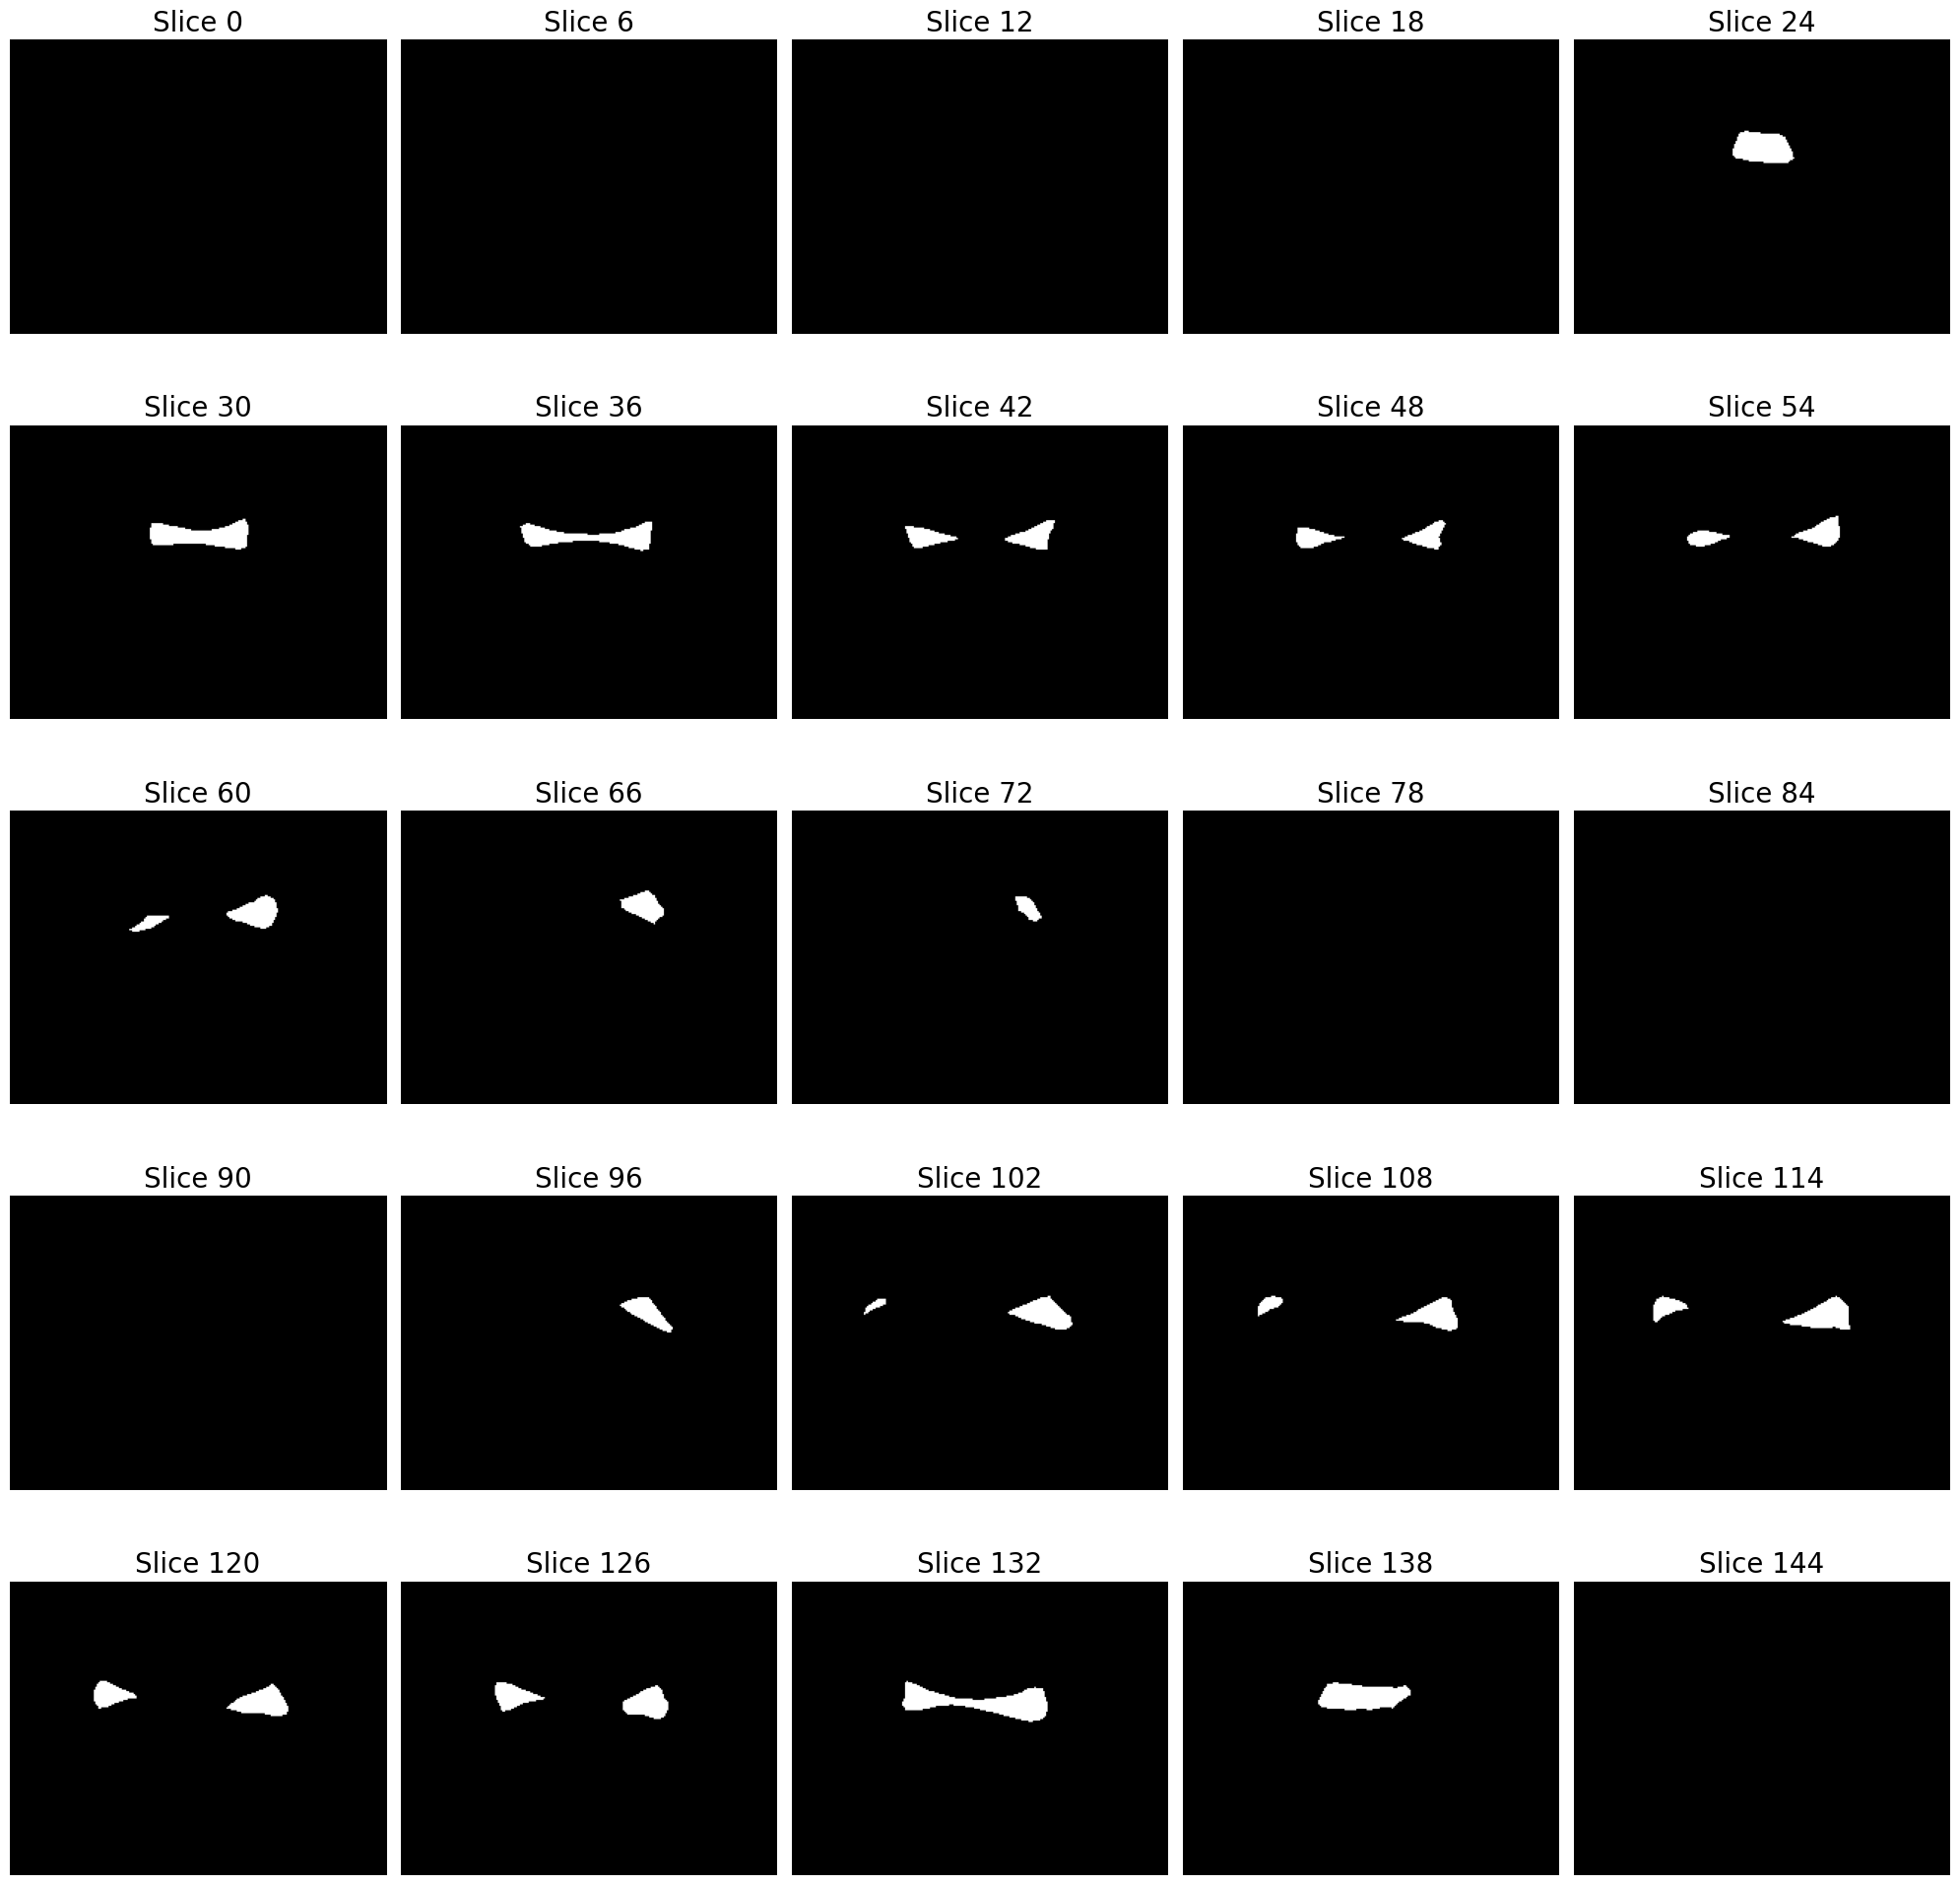

In [19]:
show_mask_slices(seg[0][0])

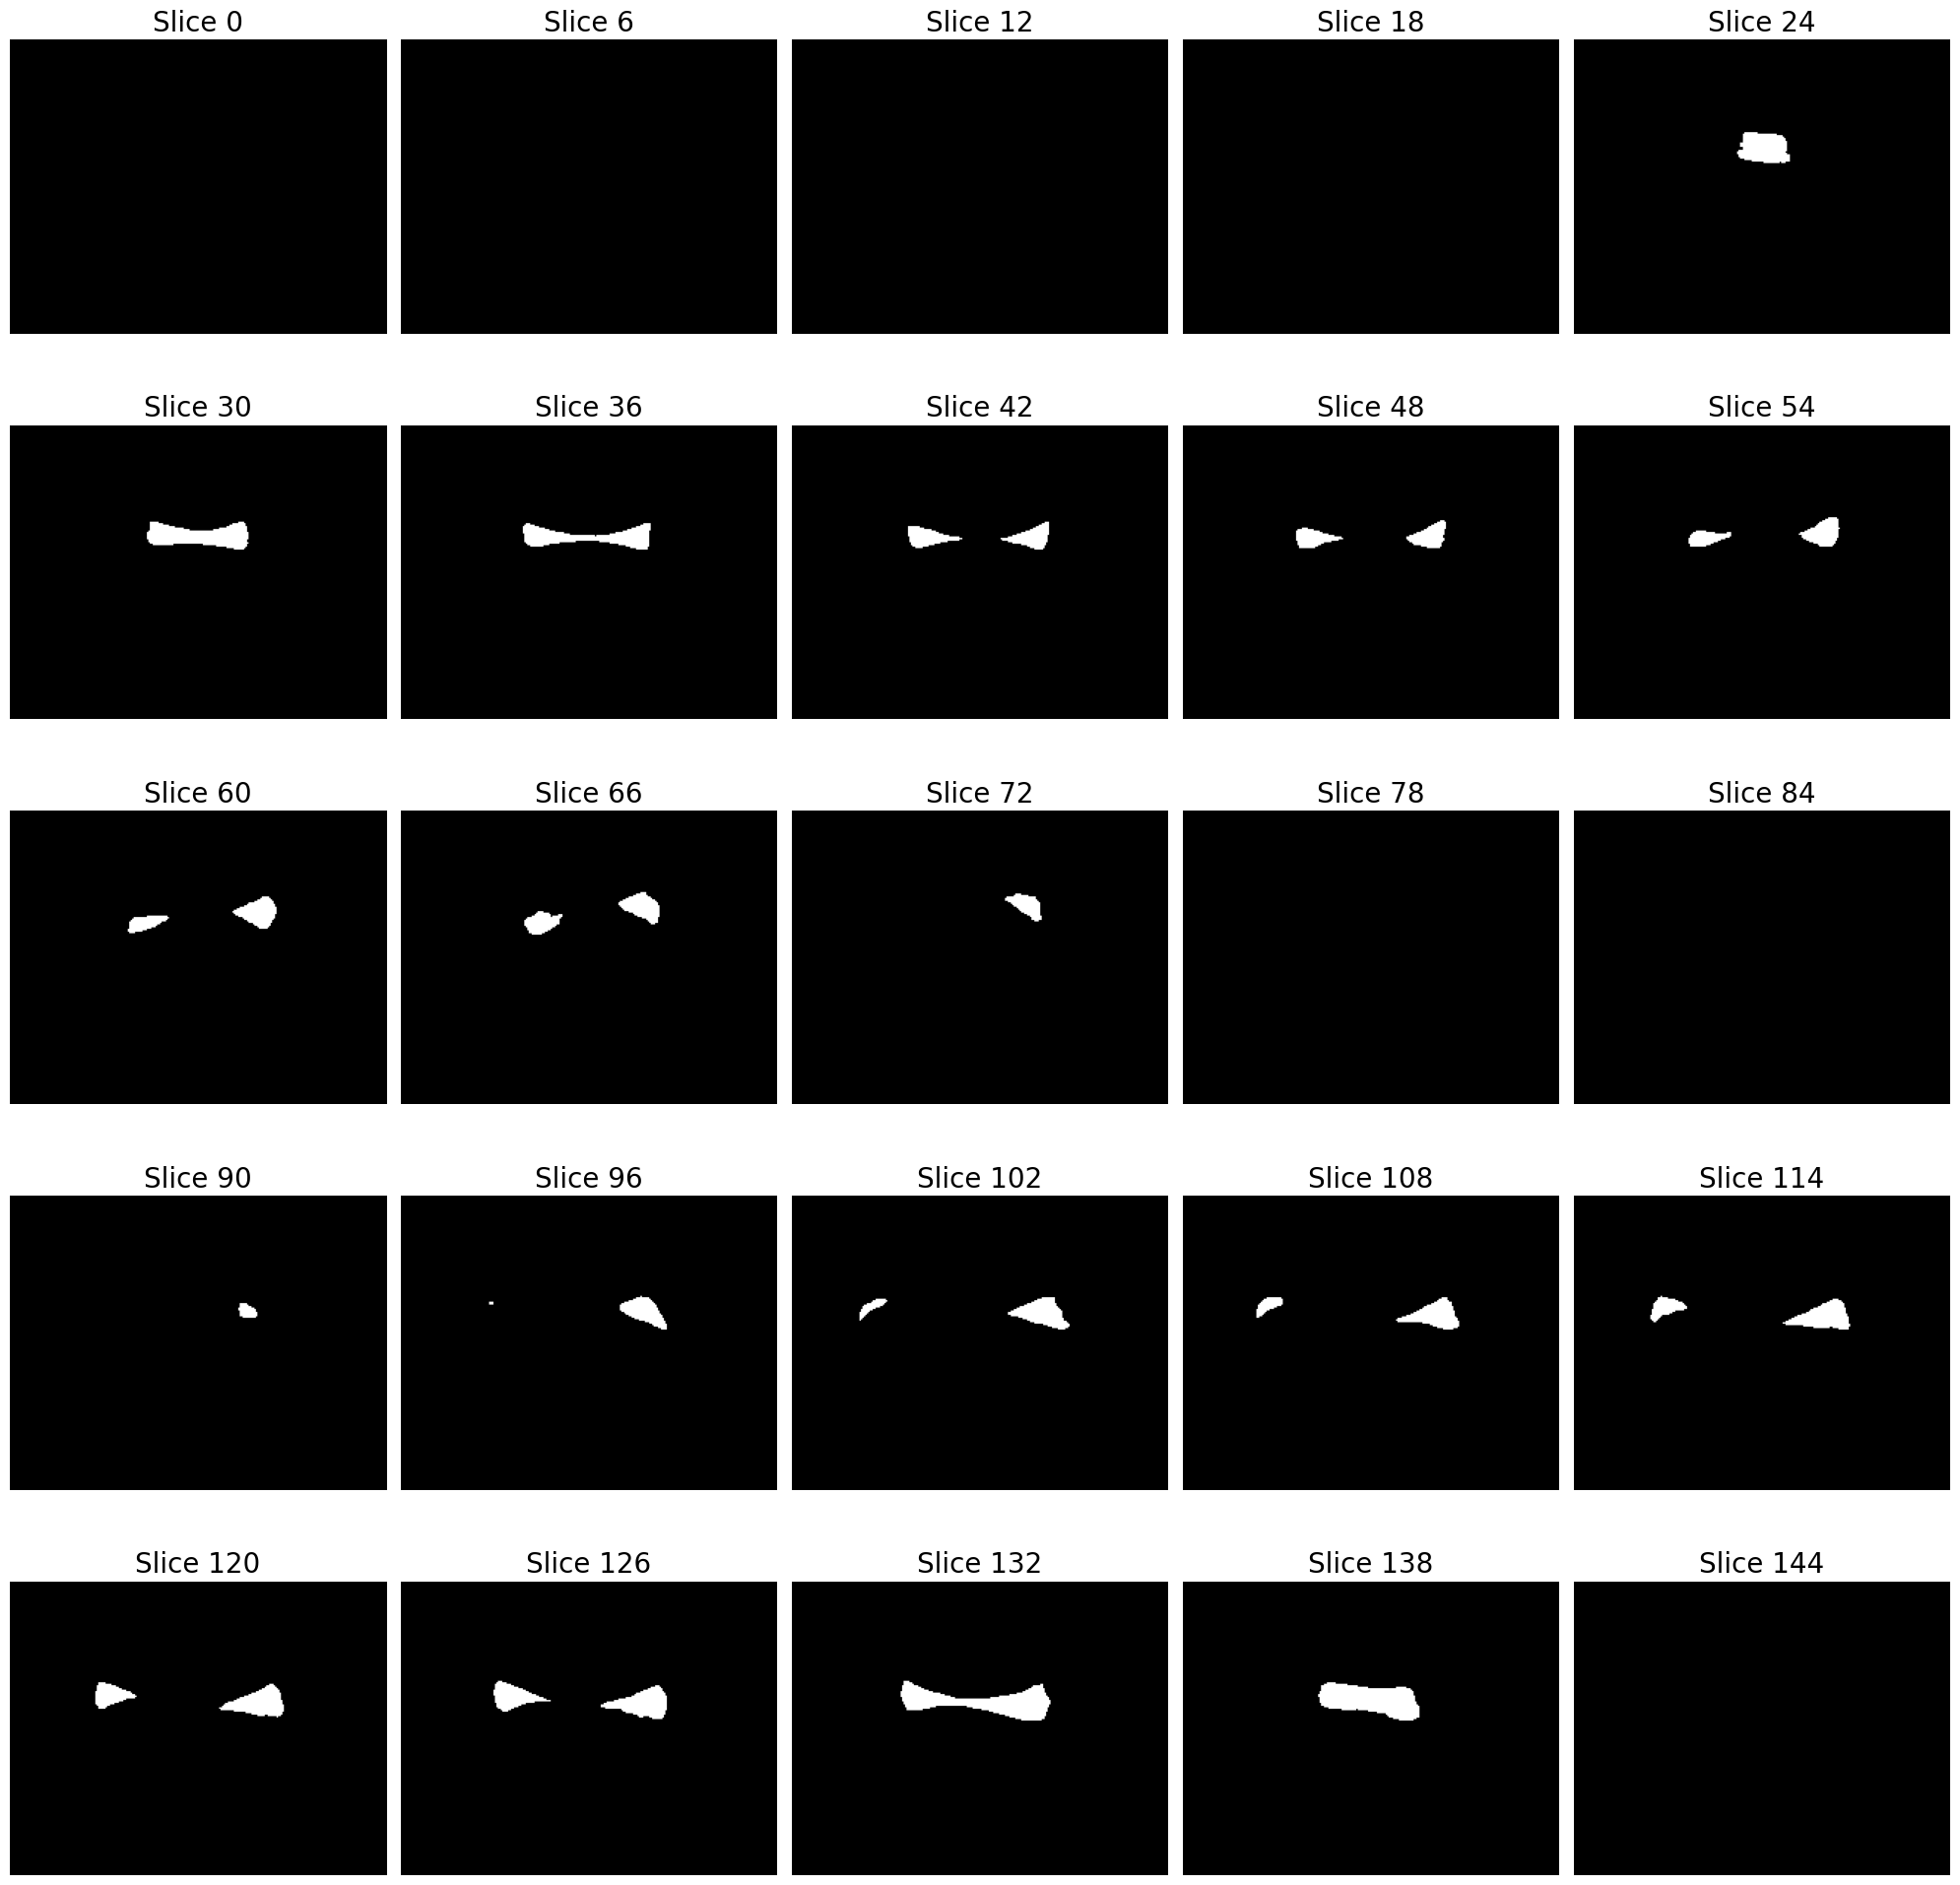

In [20]:
show_mask_slices(binary_mask)

In [ ]:
seg[0][0].numpy().shape

(200, 256, 160)

In [ ]:
np.save(f'pred_mask_{val_paths[0]}', binary_mask)

In [ ]:
ground = seg[0][0].numpy()

In [ ]:
np.sum(ground.flatten())

70402.0

In [ ]:
np.sum(binary_mask.flatten())

71923

In [ ]:
# loop through and save masks. Create dir for this
!mkdir ../data/unet_test_preds

In [21]:
sub_dir = '../data/unet_test_preds/'

In [22]:
# get dice scores, and save masks
from tqdm import tqdm

dice_scores = []

model.to(device)

for idx, (im, mask) in enumerate(tqdm(test_loader)):
    im = im.to(device)
    out = model(im)
    out = out.detach().cpu().squeeze(0).squeeze(0).numpy()

    pred_mask = (out>0.5).astype(int)

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask.squeeze(0).squeeze(0), pred_mask)
    dice_scores.append(dice)
    print(f"Im {idx+1}: Dice = {dice}")

    # save mask
    np.save(sub_dir + test_paths[idx], pred_mask)

  0%|          | 0/28 [00:00<?, ?it/s]

Im 1: Dice = 0.9165757210686698


  7%|▋         | 2/28 [00:54<11:50, 27.33s/it]

Im 2: Dice = 0.9171538298873784


 11%|█         | 3/28 [01:23<11:43, 28.15s/it]

Im 3: Dice = 0.8538558002564428


 14%|█▍        | 4/28 [01:51<11:17, 28.21s/it]

Im 4: Dice = 0.8671984477740649


 18%|█▊        | 5/28 [02:22<11:11, 29.21s/it]

Im 5: Dice = 0.8750834452804997


 21%|██▏       | 6/28 [02:49<10:23, 28.35s/it]

Im 6: Dice = 0.8555957605153078


 25%|██▌       | 7/28 [03:17<09:53, 28.25s/it]

Im 7: Dice = 0.8965312005951828


 29%|██▊       | 8/28 [03:45<09:20, 28.04s/it]

Im 8: Dice = 0.9074695324197798


 32%|███▏      | 9/28 [04:17<09:18, 29.38s/it]

Im 9: Dice = 0.8172127854929416


 36%|███▌      | 10/28 [04:55<09:38, 32.13s/it]

Im 10: Dice = 0.8460511679644049


 39%|███▉      | 11/28 [05:24<08:49, 31.15s/it]

Im 11: Dice = 0.8586600443833879


 43%|████▎     | 12/28 [06:04<09:00, 33.80s/it]

Im 12: Dice = 0.8192292687155923


 46%|████▋     | 13/28 [06:43<08:49, 35.32s/it]

Im 13: Dice = 0.8789968848818688


 50%|█████     | 14/28 [07:17<08:07, 34.85s/it]

Im 14: Dice = 0.8601401050788091


 54%|█████▎    | 15/28 [07:50<07:26, 34.38s/it]

Im 15: Dice = 0.8387756972233252


 57%|█████▋    | 16/28 [08:21<06:39, 33.25s/it]

Im 16: Dice = 0.8277266544578606


 61%|██████    | 17/28 [08:49<05:48, 31.65s/it]

Im 17: Dice = 0.8693158953722334


 64%|██████▍   | 18/28 [09:15<05:01, 30.19s/it]

Im 18: Dice = 0.8700119287063884


 68%|██████▊   | 19/28 [09:44<04:27, 29.71s/it]

Im 19: Dice = 0.9051049912309808


 71%|███████▏  | 20/28 [10:10<03:49, 28.68s/it]

Im 20: Dice = 0.8704
Im 21: Dice = 0.8908730728374149


 79%|███████▊  | 22/28 [11:02<02:43, 27.26s/it]

Im 22: Dice = 0.8767463933181473


 82%|████████▏ | 23/28 [11:28<02:14, 26.89s/it]

Im 23: Dice = 0.8802721806893534


 86%|████████▌ | 24/28 [11:54<01:46, 26.61s/it]

Im 24: Dice = 0.8638269561046557


 89%|████████▉ | 25/28 [12:19<01:18, 26.14s/it]

Im 25: Dice = 0.86810481556081


 93%|█████████▎| 26/28 [12:46<00:52, 26.32s/it]

Im 26: Dice = 0.871149650556521


 96%|█████████▋| 27/28 [13:11<00:26, 26.01s/it]

Im 27: Dice = 0.8842816334596935


100%|██████████| 28/28 [13:37<00:00, 29.19s/it]

Im 28: Dice = 0.8780021017916492


In [24]:
dice_scores = np.array(dice_scores)

In [25]:
dice_scores.mean()

0.8701552130579772

In [26]:
# save dice
np.save("unet_dice", dice_scores)

In [ ]:
# get volumes of all masks and predictions to see if it always underpredicts

from tqdm import tqdm

gt_volumes = []
pred_volumes = []
dice_scores = []
lowest_dice = 1
lowest_dice_idx = -1
count = 0

model.to(device)

for im, mask in tqdm(test_loader):
    im = im.to(device)
    out = model(im)
    out = out.detach().cpu()

    # store volumes of both gt and prediction
    gt_volumes.append(np.sum(mask[0][0].numpy().flatten()))
    pred_volumes.append(np.sum(out[0][0].numpy().flatten()))

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask, out>0.5)
    dice_scores.append(dice)
    if dice < lowest_dice:
        lowest_dice = dice
        lowest_dice_idx = count

    print(dice)

    # update count
    count += 1



  4%|▎         | 1/28 [00:04<01:49,  4.05s/it]

0.9087510704994202


  7%|▋         | 2/28 [00:06<01:16,  2.95s/it]

0.889244556427002


 11%|█         | 3/28 [00:08<01:02,  2.49s/it]

0.7345547676086426


 14%|█▍        | 4/28 [00:10<00:53,  2.24s/it]

0.8449909090995789


 18%|█▊        | 5/28 [00:11<00:48,  2.12s/it]

0.7538569569587708


 21%|██▏       | 6/28 [00:13<00:45,  2.05s/it]

0.6849184036254883


 25%|██▌       | 7/28 [00:15<00:42,  2.01s/it]

0.8125211000442505


 29%|██▊       | 8/28 [00:17<00:40,  2.05s/it]

0.8584619760513306


 32%|███▏      | 9/28 [00:20<00:39,  2.08s/it]

0.7815516591072083


 36%|███▌      | 10/28 [00:22<00:36,  2.04s/it]

0.7746058702468872


 39%|███▉      | 11/28 [00:24<00:34,  2.03s/it]

0.6706236600875854


 43%|████▎     | 12/28 [00:25<00:31,  1.98s/it]

0.6788020730018616


 46%|████▋     | 13/28 [00:27<00:29,  1.99s/it]

0.8021395802497864


 50%|█████     | 14/28 [00:30<00:28,  2.04s/it]

0.7939797639846802


 54%|█████▎    | 15/28 [00:32<00:26,  2.01s/it]

0.7134385108947754


 57%|█████▋    | 16/28 [00:34<00:24,  2.01s/it]

0.6904840469360352


 61%|██████    | 17/28 [00:35<00:21,  1.98s/it]

0.686156690120697


 64%|██████▍   | 18/28 [00:37<00:19,  1.96s/it]

0.6765522360801697


 68%|██████▊   | 19/28 [00:39<00:17,  1.92s/it]

0.8603095412254333


 71%|███████▏  | 20/28 [00:41<00:14,  1.87s/it]

0.787781298160553


 75%|███████▌  | 21/28 [00:43<00:12,  1.82s/it]

0.8808167576789856


 79%|███████▊  | 22/28 [00:45<00:11,  1.88s/it]

0.862550675868988


 82%|████████▏ | 23/28 [00:47<00:09,  1.90s/it]

0.7738033533096313


 86%|████████▌ | 24/28 [00:48<00:07,  1.87s/it]

0.7304054498672485


 89%|████████▉ | 25/28 [00:50<00:05,  1.83s/it]

0.8670502305030823


 93%|█████████▎| 26/28 [00:52<00:03,  1.80s/it]

0.7327625751495361


 96%|█████████▋| 27/28 [00:54<00:01,  1.78s/it]

0.7470932602882385


100%|██████████| 28/28 [00:55<00:00,  2.00s/it]

0.8028625845909119


In [23]:
print(f"Average dice score of test set: {np.array(dice_scores).mean()}")

Average dice score of test set: 0.8701552130579772


In [ ]:
print(f"Lowest dice score in val set was image {lowest_dice_idx} with score {lowest_dice}")

Lowest dice score in val set was image 10 with score 0.6706236600875854


In [ ]:
print(f"image {lowest_dice_idx} has path {test_paths[lowest_dice_idx]}")

image 10 has path test_006_V00


In [ ]:
gt_volumes = np.array(gt_volumes)
pred_volumes = np.array(pred_volumes)

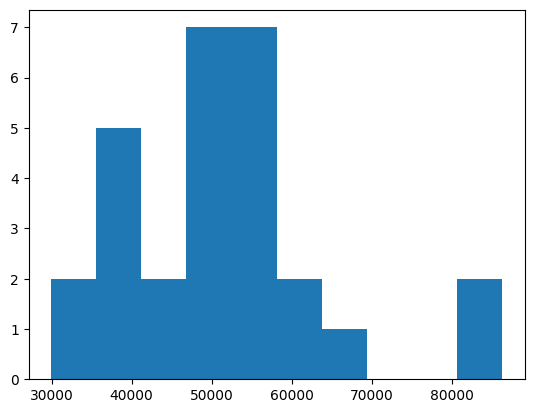

In [ ]:
import matplotlib.pyplot as plt
plt.hist(gt_volumes);

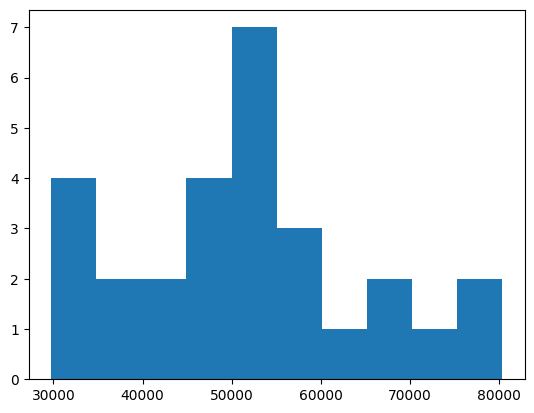

In [ ]:
plt.hist(pred_volumes);

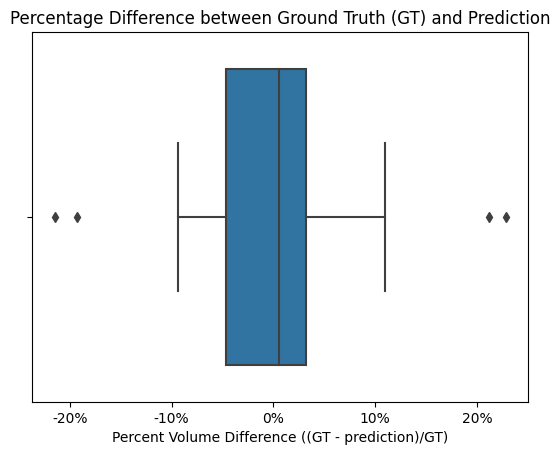

In [ ]:
import seaborn as sns
import matplotlib.ticker as mticker

# They look like they take up a similar range, so let's plot the difference between volumes for each mask
difference = gt_volumes - pred_volumes
pct_diff = difference/gt_volumes

ax = sns.boxplot(x = pct_diff)
plt.xlabel("Percent Volume Difference ((GT - prediction)/GT)")
#plt.ylabel("Difference")
plt.title("Percentage Difference between Ground Truth (GT) and Prediction")

# format x labels as percentages
def percentage_formatter(x, pos):
    return "{:.0f}%".format(x * 100)

# Apply the custom formatter to the x-axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(percentage_formatter))
plt.savefig('pct_diff_volume.png')
plt.show()

In [ ]:
# get data statistics through pandas
import pandas as pd
df = pd.DataFrame({"GT volume": gt_volumes,
                   "Pred volume": pred_volumes,
                   "Absolute pixel diff": difference,
                   "percentage diff": pct_diff})

In [ ]:
df['percentage diff'].describe()

count    28.000000
mean      0.000066
std       0.093420
min      -0.214778
25%      -0.046299
50%       0.005496
75%       0.032352
max       0.228157
Name: percentage diff, dtype: float64

In [ ]:
df['Absolute pixel diff'].describe()

count       28.000000
mean      -151.631699
std       4951.040039
min     -12480.953125
25%      -2448.984375
50%        269.634766
75%       1471.186035
max       9421.937500
Name: Absolute pixel diff, dtype: float64

In [ ]:
df

,GT volume,Pred volume,Absolute pixel diff,percentage diff
0,39507.0,31149.224609,8357.775391,0.211552
1,41075.0,31703.449219,9371.550781,0.228157
2,57996.0,69180.109375,-11184.109375,-0.192843
3,58111.0,70591.953125,-12480.953125,-0.214778
4,50110.0,49215.238281,894.761719,0.017856
5,51733.0,50871.191406,861.808594,0.016659
6,86297.0,76875.062500,9421.937500,0.109180
7,86092.0,80356.507812,5735.492188,0.066620
8,56055.0,56624.242188,-569.242188,-0.010155
9,58746.0,57310.125000,1435.875000,0.024442


In [ ]:
sorted = df.sort_values(by='GT volume')

In [ ]:
sorted

,GT volume,Pred volume,Absolute pixel diff,percentage diff
10,29948.0,30419.046875,-471.046875,-0.015729
11,31321.0,29743.880859,1577.119141,0.050353
26,37364.0,35681.621094,1682.378906,0.045027
27,39153.0,37393.882812,1759.117188,0.044929
0,39507.0,31149.224609,8357.775391,0.211552
18,40291.0,40915.250000,-624.250000,-0.015494
1,41075.0,31703.449219,9371.550781,0.228157
19,42835.0,41757.074219,1077.925781,0.025165
23,45823.0,49083.468750,-3260.468750,-0.071154
20,48087.0,47676.031250,410.968750,0.008546


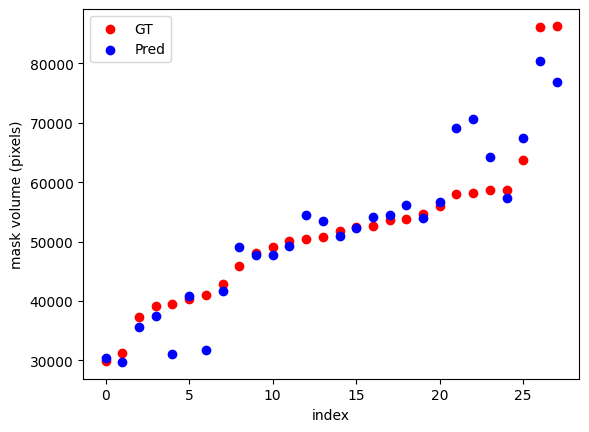

In [ ]:
# plot gt and predictions to see if the under/overestimation is related to volume of GT
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sorted)), sorted['GT volume'], color='r', label='GT')
ax.scatter(np.arange(len(sorted)), sorted['Pred volume'], color='blue', label='Pred')
ax.set_xlabel('index')
ax.set_ylabel('mask volume (pixels)')
ax.legend()
plt.show()

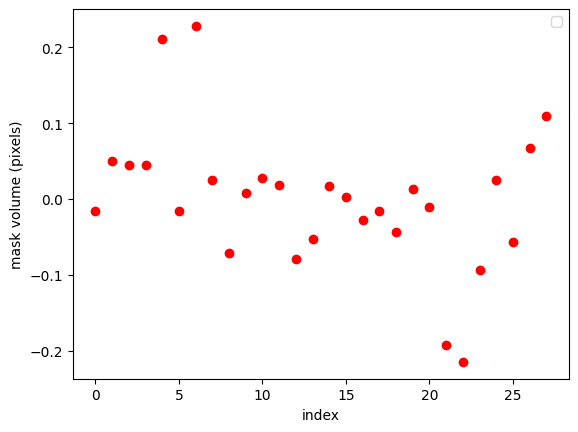

In [ ]:
# plot gt and predictions to see if the under/overestimation is related to volume of GT
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sorted)), sorted['percentage diff'], color='r')
ax.set_xlabel('index')
ax.set_ylabel('mask volume difference (percent)')
ax.legend()
plt.show()